   - 학습 데이터 (user_id : 10000 ~ 24999, 15000명)


			- train_err_data.csv : 시스템에 발생한 에러 로그

			- train_quality_data.csv : 시스템 퀄리티 로그

			- train_problem_data.csv : 사용자 불만 및 불만이 접수된 시간


   - 테스트 데이터(user_id : 30000 ~ 44998, 14999명)


			- test_err_data.csv : 시스템에 발생한 에러 로그

			- test_quality_data.csv : 시스템 퀄리티 로그

			- sample_submission.csv : 사용자 불만 확률(0~1) (제출용)

## 사용할 Module & Data 불러오기 

In [5]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import KFold
import missingno as msno
import warnings
warnings.filterwarnings(action='ignore')

In [42]:
train_err_df =pd.read_csv('../data/train_err_data.csv')
train_problem_df =pd.read_csv('../data/train_problem_data.csv')
train_quality_df =pd.read_csv('../data/train_quality_data.csv')
test_err = pd.read_csv('../data/test_err_data.csv')
test_quality = pd.read_csv('../data/test_quality_data.csv')


# err data 는 user_id 15000 명의 대한것이다

In [49]:
# pd.to_datetime(train_err_df.time)
# pd.set_option('display.max_rows)
# pandas display 할때 보여주는 최대 로우수와 컬럼수 지정  
pd.options.display.max_rows = 100
pd.options.display.max_columns = 30

In [4]:
train_err_df.head(1)

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1


- time 을 편하게 볼수있게 datatime module 로 일단 수정해서 만들어준다

In [7]:
def make_datetime(x):
    x = str(x)
    year = int(x[:4])
    month = int(x[4:6])
    day = int(x[6:8])
    hour = int(x[8:10])
    mim = int(x[10:12])
    sec = int(x[12:])
    return dt.datetime(year,month,day,hour,mim,sec)
make_datetime(20201101025616)
train_err_df['time']= train_err_df.time.map(make_datetime)

In [8]:
train_quality_df['time']= train_quality_df.time.map(make_datetime)
train_problem_df['time']= train_problem_df.time.map(make_datetime)
display(train_problem_df)
train_quality_df

,user_id,time
0,19224,2020-11-02 20:00:00
1,23664,2020-11-16 14:00:00
2,15166,2020-11-14 13:00:00
3,12590,2020-11-08 21:00:00
4,15932,2020-11-03 21:00:00
...,...,...
5424,20167,2020-11-25 12:00:00
5425,16270,2020-11-10 12:00:00
5426,19114,2020-11-06 23:00:00
5427,21505,2020-11-04 11:00:00


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0
828620,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0
828621,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0
828622,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0


In [7]:
dt.MINYEAR
dt.MAXYEAR


9999

### 불만접수를 err 데이터의 있는 모든 유저 가 불만접수를 했는지 확인

In [8]:
train_err_df.user_id.value_counts()
train_problem_df.user_id.value_counts()
train_quality_df.user_id.value_counts()
#quality user_id 8281
#problem user_id 5000
#err user_id     15000
#에러가 발생한 모든 유저가 불만 접수를 한것이 아님
# 그러면 특정 유저

15357    4224
23065    3828
22632    3744
11635    3504
16147    3336
         ... 
15301      12
15299      12
15298      12
21046      12
17539      12
Name: user_id, Length: 8281, dtype: int64

## EDA

### 0609 한것

In [9]:
train_quality_df.info() 
train_problem_df.info()
train_err_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        828624 non-null  datetime64[ns]
 1   user_id     828624 non-null  int64         
 2   fwver       788544 non-null  object        
 3   quality_0   684192 non-null  float64       
 4   quality_1   828624 non-null  int64         
 5   quality_2   788511 non-null  float64       
 6   quality_3   828624 non-null  int64         
 7   quality_4   828624 non-null  int64         
 8   quality_5   828604 non-null  object        
 9   quality_6   828624 non-null  int64         
 10  quality_7   828624 non-null  object        
 11  quality_8   828624 non-null  object        
 12  quality_9   828624 non-null  object        
 13  quality_10  828624 non-null  object        
 14  quality_11  828624 non-null  int64         
 15  quality_12  828624 non-null  int64         
dtypes:

In [10]:
null_columns = train_quality_df.columns[train_quality_df.isnull().sum() > 0].to_list()
# 이거 왜 되지 ;; 여러개 의 행의 빈값 있는 것만 찾으려했는데 조건식 만들기가 힘드네 
for column in null_columns:
    display(train_quality_df[train_quality_df[column].isnull()])

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
38316,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38317,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38318,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38319,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38320,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828331,2020-11-09 23:20:00,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828332,2020-11-09 23:20:00,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828333,2020-11-09 23:20:00,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0
828334,2020-11-09 23:20:00,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
3852,2020-11-04 02:20:00,10080,03.11.1149,NaN,-1,-1.0,0,0,-1,-1,0,0,3,1,-1,0
3853,2020-11-04 02:20:00,10080,03.11.1149,NaN,-1,-1.0,0,0,-1,-1,0,0,3,1,-1,0
3854,2020-11-04 02:20:00,10080,03.11.1149,NaN,0,2.0,0,0,1,0,0,0,3,1,0,0
3855,2020-11-04 02:20:00,10080,03.11.1149,NaN,0,1.0,0,0,0,0,0,0,3,1,0,0
3856,2020-11-04 02:20:00,10080,03.11.1149,NaN,0,0.0,0,0,0,0,0,0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828511,2020-11-21 11:30:00,24990,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,1,-1,0
828512,2020-11-21 11:30:00,24990,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,1,-1,0
828513,2020-11-21 11:30:00,24990,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0
828514,2020-11-21 11:30:00,24990,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
38316,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38317,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38318,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38319,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38320,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828331,2020-11-09 23:20:00,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828332,2020-11-09 23:20:00,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828333,2020-11-09 23:20:00,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0
828334,2020-11-09 23:20:00,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
58907,2020-11-28 23:40:00,11154,04.33.1261,0.0,0,0.0,0,0,NaN,0,0,0,0,"200,496",0,2
150490,2020-11-26 23:10:00,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,11,0,0,"843,420",0,3
150491,2020-11-26 23:10:00,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,11,0,0,"843,420",0,3
150502,2020-11-27 01:10:00,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,037,689",0,0
150503,2020-11-27 01:10:00,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,037,689",0,0
150527,2020-11-27 05:10:00,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"631,620",0,0
150538,2020-11-27 07:10:00,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,012,799",0,0
150539,2020-11-27 07:10:00,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,012,799",0,0
209696,2020-11-22 00:40:00,13720,04.22.1750,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,005,588",0,0
209697,2020-11-22 00:40:00,13720,04.22.1750,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,005,588",0,0


In [11]:
train_err_df.set_index(['user_id','errtype','model_nm']).loc[10000,'errcode']

errtype  model_nm
15       model_3     1
12       model_3     1
11       model_3     1
16       model_3     1
4        model_3     0
                    ..
15       model_3     1
16       model_3     1
4        model_3     0
         model_3     0
15       model_3     1
Name: errcode, Length: 317, dtype: object

In [12]:
np.sort(train_err_df.errtype.unique())
# 29제외 1부터 42까지 41가지 존재한다.

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42])

In [13]:
id_error = train_err_df[['user_id','errtype']].values
id_error

array([[10000,    15],
       [10000,    12],
       [10000,    11],
       ...,
       [24999,     4],
       [24999,     4],
       [24999,    15]])

<AxesSubplot:>

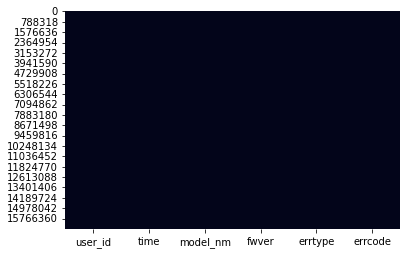

In [17]:
sns.heatmap(train_err_df.isnull(), cbar=False)

<AxesSubplot:>

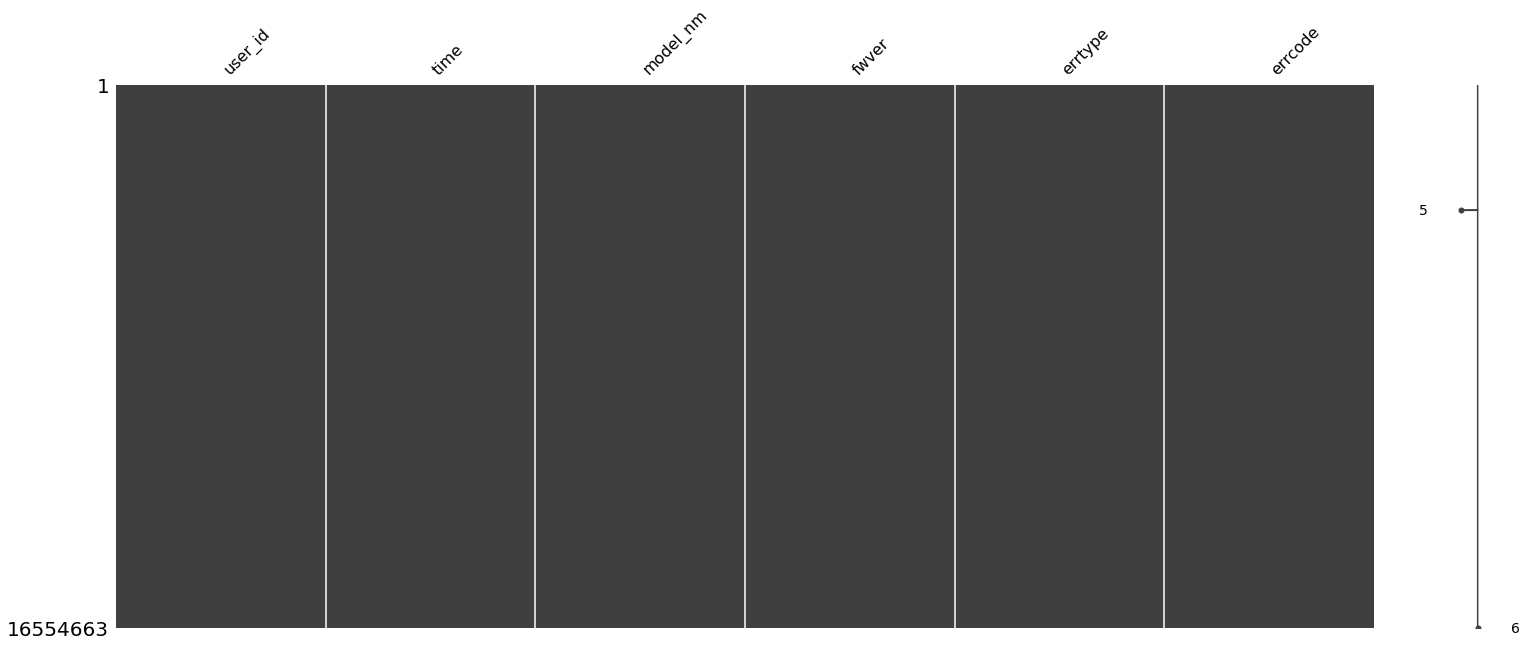

In [18]:
msno.matrix(train_err_df)

In [19]:
train_quality_df[train_quality_df.user_id == 10693]

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
38316,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38317,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38318,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38319,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38320,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38321,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38322,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38323,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38324,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38325,2020-11-20 01:00:00,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0


In [20]:
train_err_df[train_err_df.user_id == 10693]
# user_id 10693 은 model_6 만 사용했는지는 모르지만 error 이것만떳어 fwver 이 10 이라고 error 데이터에서는 보이는 그러면
# error 가 발생하고 quality 를 2시간동안 10분마다 수집하니까  근데 보면 20일에 발생한 에러는 없어 에러를 거의 2 분 3분마다 발생시키는데 
# 무슨 에러인지 모르겠네 어차피 이건 model_6 fwver 10에 대한 에러들이야

,user_id,time,model_nm,fwver,errtype,errcode
737388,10693,2020-11-19 22:31:15,model_6,10,5,B-A8002
737389,10693,2020-11-19 22:31:29,model_6,10,5,B-A8002
737390,10693,2020-11-19 22:31:50,model_6,10,5,B-A8002
737391,10693,2020-11-19 22:31:58,model_6,10,5,B-A8002
737392,10693,2020-11-19 22:32:12,model_6,10,5,B-A8002
737393,10693,2020-11-19 22:32:18,model_6,10,5,B-A8002
737394,10693,2020-11-19 22:33:08,model_6,10,5,B-A8002
737395,10693,2020-11-19 22:33:10,model_6,10,5,B-A8002
737396,10693,2020-11-19 22:33:19,model_6,10,5,B-A8002
737397,10693,2020-11-19 22:33:21,model_6,10,5,B-A8002


In [ ]:
%%time
# quailty 에서 fwver 가 nan인게 뭐뭐가 있는지 fwver 가 빈것들은 다 퀄리티 0 과 2가 비어있는지 봐보자
train_quality_df.loc[train_quality_df.fwver.isnull(),['quality_0','quality_2']].notnull().sum()
# 다 비어 있다 그러면 모델이 같은지 한번 봐보자
null_qual_0_1 = train_quality_df.loc[train_quality_df.fwver.isnull(),'user_id'].unique() # 개수는 59개

def isin_null_0_1(x):
    if x in null_qual_0_1:
        return True
    else:
        return False
null_0_1 = train_err_df[train_err_df.user_id.map(isin_null_0_1)]
'''
model_6    1639
model_0    1630
model_2     783
model_3      43
'''
null_0_1[null_0_1.model_nm == "model_6"].fwver.value_counts()
#array(['model_6', 'model_3', 'model_0', 'model_2'], dtype=object)

In [21]:
# model 종류가 몇가지나 있나 한번 봐보자 
train_err_df.model_nm.value_counts()
# 빈것들의 에러코드는 같은지 or model 이 같은지 
# 퀄리티 별 숫자가 같은지 로봐보자 

model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64

In [22]:
train_quality_df[train_quality_df.columns[3:]].iloc[:,0].value_counts(normalize=True)

 0.0       0.793330
-1.0       0.191215
 1.0       0.003065
 2.0       0.001830
 3.0       0.000757
             ...   
 1113.0    0.000001
 1177.0    0.000001
 1186.0    0.000001
 946.0     0.000001
 2351.0    0.000001
Name: quality_0, Length: 753, dtype: float64

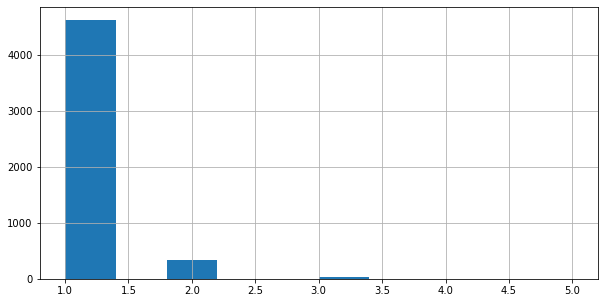

In [23]:
# null_0_1.errtype.value_counts()
# model_nm 과 error 타입을 연결시키는건 좀 힘들고
# user_id 별로 무슨 error type 이나 error code에 대한 불만을 많이 썻는지
# 그 에러들의 퀄리티 점수 분포는 어떻게 되는지 로 보면 될거같은데
# 결측 치 채우기는 다음에 위에꺼 부터
plt.figure(figsize =(10,5))
train_problem_df.user_id.value_counts().hist()
# plt.ylim(0,100)
plt.show()
# 대부분 의 고객이 불만은 한번 표시 했다

### 0610

In [98]:
train_err.info()
train_problem_df.info()
train_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15368002 entries, 0 to 15368001
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int64         
 1   time      datetime64[ns]
 2   model_nm  object        
 3   fwver     object        
 4   errtype   int64         
 5   errcode   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 703.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  5429 non-null   int64         
 1   time     5429 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 85.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        82862

In [12]:
#중복값 확인해서 똑같은걸 처리해준다
#왜냐 왜냐 음 왜일까 수학적으로 가중치를 더주게 될거라는 느낌은 무엇을 보고 느낀걸까 아마 그럴거라고 듣기만해서 일텐데 
#오차를 구하는 방식에서 똑같은 것만 있다면 우린 loss를 줄이는 방식인가 ? lgbm 이 어떤식으로 작동했던건지 기억이 안나서 잘안돼네

# train_err_df # 16553663row
# train_err= train_err_df.drop_duplicates(keep= 'last', ignore_index = True)
# train_problem_df.duplicated().sum()# 중복값 불만접수 데이터에는 없고

# 어 그러면 2시간 동안 한번씩 찍힌다고 했는데 한번만 찍힌것도 있나
# train_quality_df[train_quality_df.time.duplicated(keep=False)]
# 확인 결과 없고 당연하네

# dup_user = train_quality_df.loc[:,'user_id'].unique()
# dup_user # 처음 중복되는 값을 여기도 확인하려했었는데 반복된다고했고 time 을 에러가 뜬순간으로 처리해놔서 구별이 되게했구나 아아아아아 분 초를 없앴어
# 분초를 진짜 없앴는지 봐보자
#train_err # 일단 에러는 시분초 다 세세히 적혀있어

# train_quality_df.time.map(lambda x: x.minute).value_counts()
# quality는
'''
20    151224
0     145920
10    140652
30    133896
50    131316
40    125616
'''
# train_quality_df.time.map(lambda x: x.second).value_counts()
#0    828624 초는 다없애고 분은 10분 단위에 맞춰서 한거같다 하나하나 비교해야되는데 능력부족

# train_quality_df[train_quality_df['user_id'] ==dup_user[2]]
# 이건 에러가 뜨고 quality_0~12 가 점수가 같은지 같은에러에는 같은지 봐볼라고했다 
# 에러가 같은건 같은 시간대에 같은 user_id fwver 으로 같은 에러라고 판단했고
# 거의 같은 양상을 보이지만 완전히 같지 않기에 항상 quality가 똑같다고 볼수없다 에러가 안떳는데도 퀄리티가 찍히는 데이터는 아닌거같은데 확인은 해봐야겠고






# 품질 이 양수와 음수를 보고 품질이 음수일때 불만 접수를 하는지 
# 아 근데 에러가 떳을때 quality log 를 찍는단 말이야 그러면 그래도 의미 있을거같애
# 모델이 뭔지를 안다면 안찍히는것은 기능 유추를 해볼수 있을텐데 그것도 모르겠고
# LG 는 가전제품 생산하는 회사야 그러면 log 를 찍을수있는건가 ? 당연한건가 품질로그를?

# 불만을 표한 error 가 무엇일까 그걸 찾고 그 순간에 퀄리티 점수 는 ? ㅇㅋ 이걸로 간다 
# merge_df = pd.merge(train_problem_df,train_err , on = 'user_id')
# merge_df[merge_df['user_id'] == 19224][:100]
# 19224 	2020-11-02 20:00:00

# outlier 여부 확인도 해야겠네
# quality 유저별 펌웨어별 그리고 시간별 평균 합  분산 ? ㅇ
train_err.to_csv('train_err.csv' , index = False)

In [45]:
train_errtype = np.sort(train_err.errtype.unique())
train_errtype
test_errtype = np.sort(test_err.errtype.unique())
test_errtype == train_errtype

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [62]:
train_user_id_max= 14999
train_user_id_min= 10000
train_user_id_num= 15000

labels = np.zeros(train_user_id_num)
# print(labels.dtype)
labels[train_problem_df.user_id.unique()-10000] = 1
labels = labels.astype('int16')

def labeling(x):
    return labels[x -10000]

train_err['problem'] = train_err.user_id.map(labeling)
train_err
train_quality_df['problem']= train_quality_df.user_id.map(labeling)
train_quality_df
# 각 user_id 보고 거기다 라벨 붙이기 

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,problem
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0,1
828620,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0,1
828621,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0,1
828622,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0,1


<AxesSubplot:>

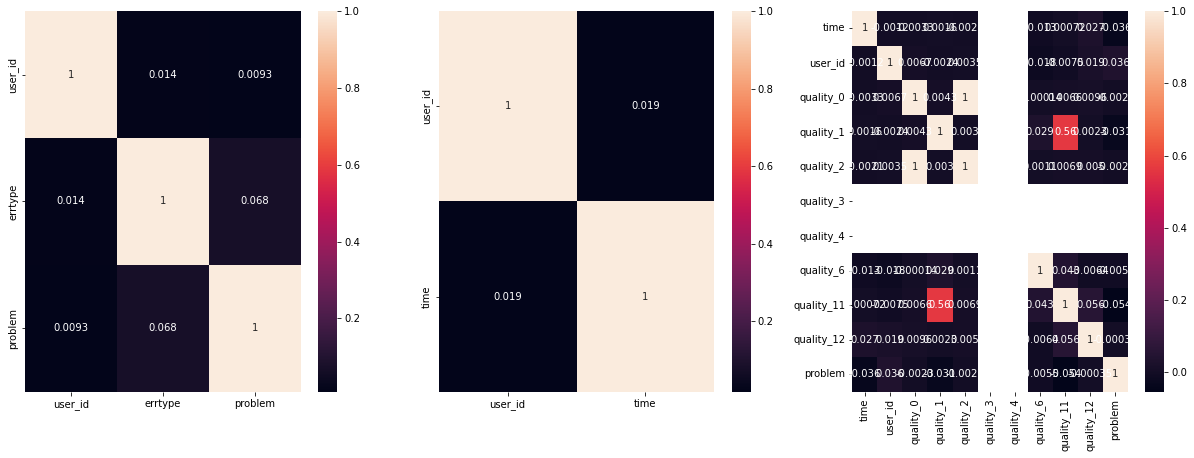

In [63]:
# re_number = re.compile("\d")
# re_number.search('6a')
# 확실히 에러 가 뜬다고 다 적은게 아니다 결측값이 있다 
# 없어 불리 할수밖에없다 
# 합쳐져 사용하고싶다 빈게 많을것이다 맞냐 틀리냐 
# 빈것을 어떻게 합쳐서 쓰냐 하면
# train Err 랑 problem 만쓴거 보다 성능이 안좋다 그러면 
# 여러개 시간별로 다양한 데이터가 있다 그러면 어떻게 사용할것이냐 ?
# 이데이터에 대해서 얼마나 이해하고있는지 고민해보고 
# 왜 이문제를 선택했는지 
# 시간 차이 테스트 랑 트레인 
# 시간차이를 봐봐야돼 퀄리티랑 에러도 보고 그렇게 다봐봐야돼
# 원하는 데이터 타입의 컬럼만 뽑기
# train_quality_df.select_dtypes('object')

fig, axs = plt.subplots(1,3, figsize = (21,7))

sns.heatmap(train_err.corr(), ax= axs[0], annot = True)
sns.heatmap(train_problem_df.corr(), ax= axs[1], annot = True)
sns.heatmap(train_quality_df.corr(), ax= axs[2], annot = True)

In [130]:
train_quality_df.corr().iloc[:,2:]
# 영향을 끼친다를 어떻게 판단하는지 영향이 있다 느껴지면 그걸 어떻게 활용하는지 모르겠다
train_quality_df.describe()
train_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       788544 non-null  object 
 3   quality_0   684192 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   788511 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828604 non-null  object 
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  object 
 11  quality_8   828624 non-null  object 
 12  quality_9   828624 non-null  object 
 13  quality_10  828624 non-null  object 
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
 16  problem     828624 non-null  int16  
dtypes: float64(2), int16(1), int64(8), object(6)
memory usage: 102.7+ MB


In [150]:
# train_quality_df['quality_5'].apply(lambda x :  0 if type(x) != str and math.isnan(x)   else int(x.replace(',','')) )
# train_quality_df[train_quality_df.iloc[:,8].isna()]
# type(train_quality_df.loc[58907].loc['quality_5'])
train_quality_df.select_dtypes('object').iloc[:,2].apply(lambda x :  0 if (type(x) != str and math.isnan(x)) int(x.replace(',','')) elif type(x) == str else x)

SyntaxError: invalid syntax (685577842.py, line 4)

In [79]:
import math
import numpy as np

In [126]:
# %%time

# b = math.nan
# print(np.isnan(b))

# a = np.nan
# print(np.isnan(a))

# (lambda x : 0.0 if math.isnan(x) else x)(train_quality_df.loc[58907].loc['quality_5'])
# train_quality_df.loc[58907].loc['quality_5']
type('str') == str

True

In [83]:
%%time

b = math.nan
print(math.isnan(b))

a = np.nan
print(math.isnan(0.1))



True
False
CPU times: user 71 µs, sys: 9 µs, total: 80 µs
Wall time: 78.2 µs


## Data Preprocessing

## Modeling & Training

## Test & measure performance